<a href="https://colab.research.google.com/github/Cesare-Caputo/PyPSA-gridtracer/blob/main/pypsa_outliar_detection_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#setup

In [ ]:
!pip install --upgrade pyod
!pip install geopandas rtree
!pip install rasterio

     |████████████████████████████████| 118 kB 5.2 MB/s 
  Created wheel for pyod: filename=pyod-1.0.0-py3-none-any.whl size=144471 sha256=77afea0e90e4b5dd528dcbd23aeb5197418eefee9aeedc8e52067350c012d973
  Stored in directory: /root/.cache/pip/wheels/37/e6/25/8098880dadf78bf063ee9b37477b1a9317e8bb0fc06e623187
Successfully built pyod
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 1.0 MB 37.6 MB/s 
     |████████████████████████████████| 16.7 MB 321 kB/s 
     |████████████████████████████████| 6.3 MB 38.3 MB/s 
     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from __future__ import division
from __future__ import print_function

import os
import sys
from time import time

import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager

# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
#from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP



from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

import pandas as pd
import geopandas as gpd

#utils

In [ ]:
def return_coords_df(df):
    gh_twr_df = df
    gh_twr_df['lon'] = gh_twr_df.geometry.apply(lambda p: p.x)
    gh_twr_df['lat'] = gh_twr_df.geometry.apply(lambda p: p.y)

    # represent points consistently as (lat, lon)
    #coords_df = gh_twr_df[['lat', 'lon']]
    coords_df = gh_twr_df[['lon', 'lat']] # for visualiszing MST which seems to flip them

    return coords_df


def return_nparr_from_df(df):
  gh_twr_hits_coords_df = return_coords_df(df)
  test_pts = gh_twr_hits_coords_df.to_numpy()
  return test_pts


def generate_clf_noisy_datasets(twr_df, mu = 0 , sigma = .1):
    import numpy as np
    X = return_nparr_from_df(twr_df)
    y = np.zeros(X.shape[0])

    ## create noise for classifier ####
    noise = np.random.normal(mu, sigma, X.shape)

    noisy_X = X + noise
    noisy_y = np.ones(noisy_X.shape[0])
    X_gen = np.concatenate((X, noisy_X))
    y_gen = np.concatenate((y, noisy_y))
    return X_gen, y_gen

In [ ]:
from pyod.utils.data import check_consistent_shape
from pyod.utils.data import get_outliers_inliers
def visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
              y_test_pred, show_figure=True,
              save_figure=False):  # pragma: no cover
    """Utility function for visualizing the results in examples.
    Internal use only.
    Parameters
    ----------
    clf_name : str
        The name of the detector.
    X_train : numpy array of shape (n_samples, n_features)
        The training samples.
    y_train : list or array of shape (n_samples,)
        The ground truth of training samples.
    X_test : numpy array of shape (n_samples, n_features)
        The test samples.
    y_test : list or array of shape (n_samples,)
        The ground truth of test samples.
    y_train_pred : numpy array of shape (n_samples, n_features)
        The predicted binary labels of the training samples.
    y_test_pred : numpy array of shape (n_samples, n_features)
        The predicted binary labels of the test samples.
    show_figure : bool, optional (default=True)
        If set to True, show the figure.
    save_figure : bool, optional (default=False)
        If set to True, save the figure to the local.
    """

    def _add_sub_plot(X_inliers, X_outliers, sub_plot_title,
                      inlier_color='blue', outlier_color='orange'):
        """Internal method to add subplot of inliers and outliers.
        Parameters
        ----------
        X_inliers : numpy array of shape (n_samples, n_features)
            Outliers.
        X_outliers : numpy array of shape (n_samples, n_features)
            Inliers.
        sub_plot_title : str
            Subplot title.
        inlier_color : str, optional (default='blue')
            The color of inliers.
        outlier_color : str, optional (default='orange')
            The color of outliers.
        """
        plt.axis("equal")
        plt.scatter(X_inliers[:, 0], X_inliers[:, 1], label='inliers',
                    color=inlier_color, s=4, alpha = .7)
        plt.scatter(X_outliers[:, 0], X_outliers[:, 1],
                    label='outliers', color=outlier_color, s=5, alpha = .3, marker='^')
        plt.title(sub_plot_title, fontsize=15)
        plt.xticks([])
        plt.yticks([])
        plt.legend(loc=3, prop={'size': 10})

    # check input data shapes are consistent
    X_train, y_train, X_test, y_test, y_train_pred, y_test_pred = \
        check_consistent_shape(X_train, y_train, X_test, y_test, y_train_pred,
                               y_test_pred)

    if X_train.shape[1] != 2:
        raise ValueError("Input data has to be 2-d for visualization. The "
                         "input data has {shape}.".format(shape=X_train.shape))

    X_train_outliers, X_train_inliers = get_outliers_inliers(X_train, y_train)
    X_train_outliers_pred, X_train_inliers_pred = get_outliers_inliers(
        X_train, y_train_pred)

    X_test_outliers, X_test_inliers = get_outliers_inliers(X_test, y_test)
    X_test_outliers_pred, X_test_inliers_pred = get_outliers_inliers(
        X_test, y_test_pred)

    # plot ground truth vs. predicted results
    fig = plt.figure(figsize=(12, 10))
    plt.suptitle("Demo of {clf_name} Detector".format(clf_name=clf_name),
                 fontsize=15)

    fig.add_subplot(221)
    _add_sub_plot(X_train_inliers, X_train_outliers, 'Train Set Ground Truth',
                  inlier_color='blue', outlier_color='orange')

    fig.add_subplot(222)
    _add_sub_plot(X_train_inliers_pred, X_train_outliers_pred,
                  'Train Set Prediction', inlier_color='blue',
                  outlier_color='orange')

    fig.add_subplot(223)
    _add_sub_plot(X_test_inliers, X_test_outliers, 'Test Set Ground Truth',
                  inlier_color='green', outlier_color='red')

    fig.add_subplot(224)
    _add_sub_plot(X_test_inliers_pred, X_test_outliers_pred,
                  'Test Set Prediction', inlier_color='green',
                  outlier_color='red')

    if save_figure:
        plt.savefig('{clf_name}.png'.format(clf_name=clf_name), dpi=300)

    if show_figure:
        plt.show()

# generate datasets for classifier

##load tower OSM data for maxar countries

In [ ]:
dirs = ['ghana']
country_dict = { 'ghana':'GH'}
base_path = os.path.join('/content', 'drive', 'My Drive', 'PyPSA_Africa_images')
out_path = os.path.join(base_path, 'MAXAR_256')

for country in dirs:
    country_code = country_dict[country]
    max_ratio = 1.
    print(f"Making Examples for {country}!")

    # assess satellite imagery
    data_path = os.path.join(base_path, 'maxar', country, 'raw')

    #coverage_polygon = make_examples.make_polygon_list(data_path)
    lines_file = os.path.join(data_path, f"{country_code}_raw_lines.geojson")
    towers_file = os.path.join(data_path, f"{country_code}_raw_towers.geojson")

    gh_line_df = gpd.read_file(lines_file) # ground truth
    gh_twr_df = gpd.read_file(towers_file) # input into algo

Making Examples for ghana!


In [ ]:
dirs = ['sierra_leone']
country_dict = {'sierra_leone': 'SL'}
base_path = os.path.join('/content', 'drive', 'My Drive', 'PyPSA_Africa_images')
out_path = os.path.join(base_path, 'MAXAR_256')

for country in dirs:
    country_code = country_dict[country]
    max_ratio = 1.
    print(f"Making Examples for {country}!")

    # assess satellite imagery

    data_path = os.path.join(base_path, 'maxar', country, 'raw')

    #coverage_polygon = make_examples.make_polygon_list(data_path)
    towers_file = os.path.join(data_path, f"{country_code}_raw_towers.geojson")
    lines_file = os.path.join(data_path, f"{country_code}_raw_lines.geojson")

    sl_twr_df = gpd.read_file(towers_file)

    sl_line_df = gpd.read_file(lines_file)

Making Examples for sierra_leone!


In [ ]:
dirs = ['malawi']
country_dict = {'malawi': 'MW'}
base_path = os.path.join('/content', 'drive', 'My Drive', 'PyPSA_Africa_images')
out_path = os.path.join(base_path, 'MAXAR_256')

for country in dirs:
    country_code = country_dict[country]
    max_ratio = 1.
    print(f"Making Examples for {country}!")

    # assess satellite imagery

    data_path = os.path.join(base_path, 'maxar', country, 'raw')

    #coverage_polygon = make_examples.make_polygon_list(data_path)
    towers_file = os.path.join(data_path, f"{country_code}_raw_towers.geojson")
    lines_file = os.path.join(data_path, f"{country_code}_raw_lines.geojson")

    mw_twr_df = gpd.read_file(towers_file)

    mw_line_df = gpd.read_file(lines_file)

Making Examples for malawi!


In [ ]:
dirs = ['chad']
country_dict = {'chad': 'TD'}
base_path = os.path.join('/content', 'drive', 'My Drive', 'PyPSA_Africa_images')
out_path = os.path.join(base_path, 'MAXAR_256')

for country in dirs:
    country_code = country_dict[country]
    max_ratio = 1.
    print(f"Making Examples for {country}!")

    # assess satellite imagery

    data_path = os.path.join(base_path, 'maxar', country, 'raw')

    #coverage_polygon = make_examples.make_polygon_list(data_path)
    towers_file = os.path.join(data_path, f"{country_code}_raw_towers.geojson")
    lines_file = os.path.join(data_path, f"{country_code}_raw_lines.geojson")

    ch_twr_df = gpd.read_file(towers_file)

    ch_line_df = gpd.read_file(lines_file)


Making Examples for chad!


## add noise and convert to array format in lon lat

In [ ]:
maxar_twr_df = gpd.GeoDataFrame(pd.concat([ch_twr_df, gh_twr_df, mw_twr_df, sl_twr_df], ignore_index = True))
maxar_twr_df.head()

,id,tags.power,tags.ref,Type,Country,geometry,tags.material,tags.height,tags.structure,tags.line_management,tags.operator
0,6.225625e+09,tower,None,Node,TD,POINT (15.12929 12.14937),NaN,NaN,NaN,NaN,NaN
1,5.938765e+09,tower,None,Node,TD,POINT (16.73191 10.28529),NaN,NaN,NaN,NaN,NaN
2,5.938765e+09,tower,None,Node,TD,POINT (16.73693 10.28394),NaN,NaN,NaN,NaN,NaN
3,6.225625e+09,tower,None,Node,TD,POINT (15.10714 12.17727),NaN,NaN,NaN,NaN,NaN
4,5.938765e+09,tower,None,Node,TD,POINT (16.84126 10.20589),NaN,NaN,NaN,NaN,NaN


In [ ]:
maxar_twr_df.tail()

,id,tags.power,tags.ref,Type,Country,geometry,tags.material,tags.height,tags.structure,tags.line_management,tags.operator
21474,3.166191e+09,tower,NaN,Node,sierra-leone,POINT (-12.77661 8.51718),NaN,NaN,NaN,NaN,NaN
21475,2.088170e+09,tower,NaN,Node,sierra-leone,POINT (-12.18536 8.83500),NaN,NaN,NaN,NaN,NaN
21476,8.668409e+09,tower,NaN,Node,sierra-leone,POINT (-12.22714 8.74219),NaN,NaN,NaN,NaN,NaN
21477,2.179090e+09,tower,NaN,Node,sierra-leone,POINT (-13.05836 8.32456),NaN,NaN,NaN,NaN,NaN
21478,2.179091e+09,tower,NaN,Node,sierra-leone,POINT (-13.02260 8.32977),NaN,NaN,NaN,NaN,NaN


In [ ]:
X, y = generate_clf_noisy_datasets(gh_twr_df)

# compare performance of model alternatives

In [ ]:
from sklearn.model_selection import train_test_split
from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score


# define the number of iterations
n_ite = 10
n_classifiers = 10

df_columns = ['Data', '#Samples', '# Dimensions', 'Outlier Perc',
              'ABOD', 'CBLOF', 'HBOS', 'IForest', 'KNN', 'LOF',
              'MCD', 'OCSVM', 'PCA']

# initialize the container for saving the results
roc_df = pd.DataFrame(columns=df_columns)
prn_df = pd.DataFrame(columns=df_columns)
time_df = pd.DataFrame(columns=df_columns)

X = X
y= y

outliers_fraction = np.count_nonzero(y) / len(y)
outliers_percentage = round(outliers_fraction * 100, ndigits=4)

# construct containers for saving results
roc_list = [ X.shape[0], X.shape[1], outliers_percentage]
prn_list = [ X.shape[0], X.shape[1], outliers_percentage]
time_list = [X.shape[0], X.shape[1], outliers_percentage]

roc_mat = np.zeros([n_ite, n_classifiers])
prn_mat = np.zeros([n_ite, n_classifiers])
time_mat = np.zeros([n_ite, n_classifiers])

for i in range(n_ite):
    print("ProcessingIteration'", i + 1)
    random_state = np.random.RandomState(i)

    # 60% data for training and 40% for testing
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.4, random_state=random_state)

    # standardizing data for processing
    X_train_norm, X_test_norm = standardizer(X_train, X_test)

    classifiers = {'Angle-based Outlier Detector (ABOD)': ABOD(
        contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor': CBLOF(
            n_clusters=10,
            contamination=outliers_fraction,
            check_estimator=False,
            random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(
            contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,
                                    random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Local Outlier Factor (LOF)': LOF(
            contamination=outliers_fraction),
        'Minimum Covariance Determinant (MCD)': MCD(
            contamination=outliers_fraction, random_state=random_state),
        'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
        'Principal Component Analysis (PCA)': PCA(
            contamination=outliers_fraction, random_state=random_state),
    }
    classifiers_indices = {
        'Angle-based Outlier Detector (ABOD)': 0,
        'Cluster-based Local Outlier Factor': 1,
        'Histogram-base Outlier Detection (HBOS)': 3,
        'Isolation Forest': 4,
        'K Nearest Neighbors (KNN)': 5,
        'Local Outlier Factor (LOF)': 6,
        'Minimum Covariance Determinant (MCD)': 7,
        'One-class SVM (OCSVM)': 8,
        'Principal Component Analysis (PCA)': 9,
    }

    for clf_name, clf in classifiers.items():
        t0 = time()
        clf.fit(X_train_norm)
        test_scores = clf.decision_function(X_test_norm)
        t1 = time()
        duration = round(t1 - t0, ndigits=4)

        roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
        prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

        print('{clf_name} ROC:{roc}, precision @ rank n:{prn}, '
              'execution time: {duration}s'.format(
            clf_name=clf_name, roc=roc, prn=prn, duration=duration))

        time_mat[i, classifiers_indices[clf_name]] = duration
        roc_mat[i, classifiers_indices[clf_name]] = roc
        prn_mat[i, classifiers_indices[clf_name]] = prn

time_list = time_list + np.mean(time_mat, axis=0).tolist()
temp_df = pd.DataFrame(time_list).transpose()
temp_df.columns = df_columns
time_df = pd.concat([time_df, temp_df], axis=0)

roc_list = roc_list + np.mean(roc_mat, axis=0).tolist()
temp_df = pd.DataFrame(roc_list).transpose()
temp_df.columns = df_columns
roc_df = pd.concat([roc_df, temp_df], axis=0)

prn_list = prn_list + np.mean(prn_mat, axis=0).tolist()
temp_df = pd.DataFrame(prn_list).transpose()
temp_df.columns = df_columns
prn_df = pd.concat([prn_df, temp_df], axis=0)




ProcessingIteration' 1
Angle-based Outlier Detector (ABOD) ROC:0.9618, precision @ rank n:0.9067, execution time: 10.6272s
Cluster-based Local Outlier Factor ROC:0.5057, precision @ rank n:0.5074, execution time: 2.0704s
Histogram-base Outlier Detection (HBOS) ROC:0.505, precision @ rank n:0.5063, execution time: 1.8802s
Isolation Forest ROC:0.5324, precision @ rank n:0.5302, execution time: 2.4205s
K Nearest Neighbors (KNN) ROC:0.9196, precision @ rank n:0.8414, execution time: 1.1615s
Local Outlier Factor (LOF) ROC:0.8581, precision @ rank n:0.7835, execution time: 0.2347s
Minimum Covariance Determinant (MCD) ROC:0.5001, precision @ rank n:0.5012, execution time: 5.9195s
One-class SVM (OCSVM) ROC:0.5005, precision @ rank n:0.5015, execution time: 68.3227s
Principal Component Analysis (PCA) ROC:0.4942, precision @ rank n:0.5012, execution time: 0.011s
ProcessingIteration' 2
Angle-based Outlier Detector (ABOD) ROC:0.9585, precision @ rank n:0.9057, execution time: 6.3217s
Cluster-based

based on the above, ABOD, KNN or LOF could be good options

#ECOD/CBLOF model

https://arxiv.org/abs/2201.00382

In [ ]:
from pyod.models.cblof import CBLOF
clf = CBLOF()
#clf.fit(X_train)
clf.fit(X_train_norm)
test_scores = clf.decision_function(X_test_norm)
#t1 = time()
#duration = round(t1 - t0, ndigits=4)

roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

print('{clf_name} ROC:{roc}, precision @ rank n:{prn}, '
      'execution time: {duration}s'.format(
    clf_name=clf_name, roc=roc, prn=prn, duration=duration))

LOF ROC:0.5027, precision @ rank n:0.5065, execution time: 2064.9308s


In [ ]:
from pyod.models.ecod import ECOD
clf_name = 'ECOD'
clf = ECOD()
#clf.fit(X_train)
clf.fit(X_train_norm)
test_scores = clf.decision_function(X_test_norm)
#t1 = time()
#duration = round(t1 - t0, ndigits=4)

roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

print('{clf_name} ROC:{roc}, precision @ rank n:{prn}, '
      'execution time: {duration}s'.format(
    clf_name=clf_name, roc=roc, prn=prn, duration=duration))

In [ ]:
# get outlier scores
y_train_scores = clf.decision_scores_  # raw outlier scores on the train data
y_test_scores = clf.decision_function(X_test)  # predict raw outlier scores on test

In [ ]:
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

# inference function on new data points

In [ ]:
from sklearn.model_selection import train_test_split
from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
# train LOF detector
clf_name = 'LOF'
clf = LOF(contamination = .5)
clf.fit(X_train)

LOF(algorithm='auto', contamination=0.5, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2)

In [ ]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

In [ ]:
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
LOF ROC:0.8622, precision @ rank n:0.7878

On Test Data:
LOF ROC:0.8655, precision @ rank n:0.7871


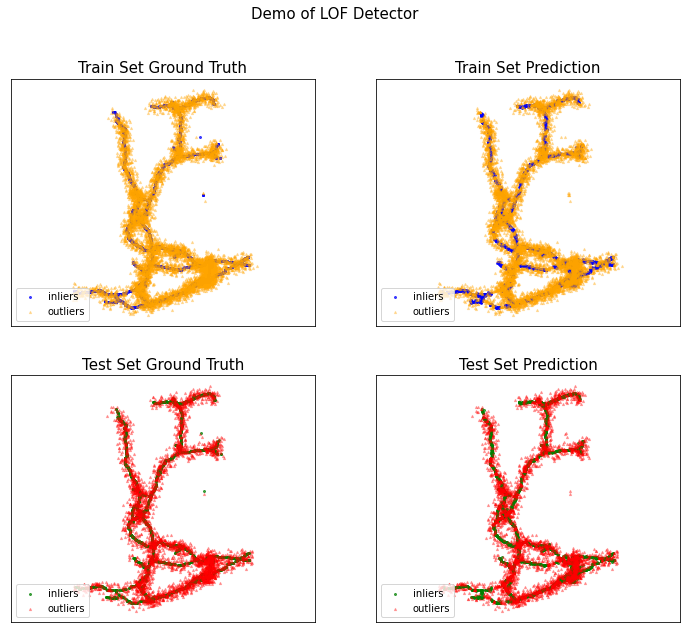

In [ ]:
# visualize the results
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
        y_test_pred, show_figure=True, save_figure=False)

#save model to use in other scripts

In [ ]:
from joblib import dump, load
model_name = 'grid_outlier_detection_v1.joblib'

model_path = '/content/drive/MyDrive/PyPSA_Africa_images/models/outlier_detection/'+model_name
# save the model
dump(clf, model_path)
# load the model
#clf = load('grid_outlier_detection_v1.joblib')

['/content/drive/MyDrive/PyPSA_Africa_images/models/outlier_detection/grid_outlier_detection_v1.joblib']

In [ ]:
def grid_outlier_inference(model_path, twr_df):
    clf = load(model_path)
    X = return_nparr_from_df(twr_df)
    # get the prediction on the new data
    y_test_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X)  # outlier scores
    return y_test_pred, y_test_scores


In [ ]:
#model_path = 'grid_outlier_detection.joblib'
twr_df = maxar_twr_df[0:500]
grid_outlier_inference(model_path, twr_df)

In [ ]:
clf = load(model_path)

In [ ]:
twr_df = maxar_twr_df[500:1000]
X = return_nparr_from_df(twr_df)
y_test_pred = clf.predict(X)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X)  # outlier scores
print(y_test_pred)
print(y_test_scores)

[0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0
 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0
 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 1 0 1 0 0 

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


#compare all model options